In [1]:
#import relevant libraries that I am likely to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For string manipulation
import re #regular expressions
import string

# For text pre-processing, the natural language toolkit
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

# For assigning sentiment polarity scores
from textblob import TextBlob

# For extracting features -- i.e. the document-term matrix
from sklearn.feature_extraction.text import CountVectorizer

# For splitting the data into a training and a testing set
from sklearn.model_selection import train_test_split

# For using Naive Bayes - the typical basic machine learning algorithm of choice for Text analytics
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# For evaluating our machine learning model 
from sklearn.metrics import accuracy_score, classification_report

In [2]:
#I have exported my data as a csv file from the Analytics page on twitter for the 28days prior to day of export
#import data from csv file into a pandas dataframe and have a look at what's there
tweet_data = pd.read_csv("TweetActivity.csv")
tweet_data.head()

,Tweet id,Tweet permalink,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,...,promoted hashtag clicks,promoted detail expands,promoted permalink clicks,promoted app opens,promoted app installs,promoted follows,promoted email tweet,promoted dial phone,promoted media views,promoted media engagements
0,1228286336156733443,https://twitter.com/ShrutiTurner/status/122828...,Slow progress is better than no progress. #PhD...,2020-02-14 11:54 +0000,117.0,1.0,0.008547,0.0,0.0,1.0,...,-,-,-,-,-,-,-,-,-,-
1,1228269557074272256,https://twitter.com/ShrutiTurner/status/122826...,"Racism is not okay. Not in medicine, not in an...",2020-02-14 10:47 +0000,226.0,3.0,0.013274,0.0,0.0,1.0,...,-,-,-,-,-,-,-,-,-,-
2,1228254359735144448,https://twitter.com/ShrutiTurner/status/122825...,"Roses are red,\nViolets are blue,\nI want to u...",2020-02-14 09:47 +0000,1110.0,14.0,0.012613,2.0,0.0,2.0,...,-,-,-,-,-,-,-,-,-,-
3,1227990530736508928,https://twitter.com/ShrutiTurner/status/122799...,@OpenAcademics 🇬🇧🇬🇧🇬🇧 https://t.co/NSf4DVxj1L,2020-02-13 16:18 +0000,104.0,4.0,0.038462,0.0,0.0,1.0,...,-,-,-,-,-,-,-,-,-,-
4,1227563986725543937,https://twitter.com/ShrutiTurner/status/122756...,@itsJozefwithaZ @OpenAcademics @AcademicChatte...,2020-02-12 12:03 +0000,152.0,1.0,0.006579,0.0,0.0,1.0,...,-,-,-,-,-,-,-,-,-,-


There is a lot of data contained in each column, much of it looks to contain no relevant information, but also I can't see all the columns as there are too many. To get a fuller picture of the data that I've got I'll check the column titles.

In [3]:
#check the column titles to see what data is present
tweet_data.columns

Index(['Tweet id', 'Tweet permalink', 'Tweet text', 'time', 'impressions',
       'engagements', 'engagement rate', 'retweets', 'replies', 'likes',
       'user profile clicks', 'url clicks', 'hashtag clicks', 'detail expands',
       'permalink clicks', 'app opens', 'app installs', 'follows',
       'email tweet', 'dial phone', 'media views', 'media engagements',
       'promoted impressions', 'promoted engagements',
       'promoted engagement rate', 'promoted retweets', 'promoted replies',
       'promoted likes', 'promoted user profile clicks', 'promoted url clicks',
       'promoted hashtag clicks', 'promoted detail expands',
       'promoted permalink clicks', 'promoted app opens',
       'promoted app installs', 'promoted follows', 'promoted email tweet',
       'promoted dial phone', 'promoted media views',
       'promoted media engagements'],
      dtype='object')

In [4]:
#remove all the columns that start with "promoted" because I know that I haven't promoted any of my tweets and so these
#columns aren't any use to me
useful_columns = [c for c in tweet_data.columns if c.lower()[:8] != 'promoted']
tweet_data = tweet_data[useful_columns]
tweet_data.head()

,Tweet id,Tweet permalink,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,...,hashtag clicks,detail expands,permalink clicks,app opens,app installs,follows,email tweet,dial phone,media views,media engagements
0,1228286336156733443,https://twitter.com/ShrutiTurner/status/122828...,Slow progress is better than no progress. #PhD...,2020-02-14 11:54 +0000,117.0,1.0,0.008547,0.0,0.0,1.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,1228269557074272256,https://twitter.com/ShrutiTurner/status/122826...,"Racism is not okay. Not in medicine, not in an...",2020-02-14 10:47 +0000,226.0,3.0,0.013274,0.0,0.0,1.0,...,0.0,2.0,0.0,0,0,0,0,0,0,0
2,1228254359735144448,https://twitter.com/ShrutiTurner/status/122825...,"Roses are red,\nViolets are blue,\nI want to u...",2020-02-14 09:47 +0000,1110.0,14.0,0.012613,2.0,0.0,2.0,...,2.0,0.0,0.0,0,0,0,0,0,151,4
3,1227990530736508928,https://twitter.com/ShrutiTurner/status/122799...,@OpenAcademics 🇬🇧🇬🇧🇬🇧 https://t.co/NSf4DVxj1L,2020-02-13 16:18 +0000,104.0,4.0,0.038462,0.0,0.0,1.0,...,0.0,0.0,0.0,0,0,0,0,0,25,1
4,1227563986725543937,https://twitter.com/ShrutiTurner/status/122756...,@itsJozefwithaZ @OpenAcademics @AcademicChatte...,2020-02-12 12:03 +0000,152.0,1.0,0.006579,0.0,0.0,1.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [5]:
#I'm now going to drop the other columns that I'm not interested in
tweet_data = tweet_data.drop(['Tweet id', 'Tweet permalink'], axis = 1)

In [6]:
#Before I do any further analysis, I want to check the types of the data that I have in the dataframe
tweet_data.dtypes

Tweet text              object
time                    object
impressions            float64
engagements            float64
engagement rate        float64
retweets               float64
replies                float64
likes                  float64
user profile clicks    float64
url clicks             float64
hashtag clicks         float64
detail expands         float64
permalink clicks       float64
app opens                int64
app installs             int64
follows                  int64
email tweet              int64
dial phone               int64
media views              int64
media engagements        int64
dtype: object

All the datatypes are as I would expect for the given titles, except for time, which is an object which I would rather be in datetime format.

In [7]:
#convert time column to datatime type and check
tweet_data['time'] = pd.to_datetime(tweet_data['time'])
tweet_data.dtypes

Tweet text                          object
time                   datetime64[ns, UTC]
impressions                        float64
engagements                        float64
engagement rate                    float64
retweets                           float64
replies                            float64
likes                              float64
user profile clicks                float64
url clicks                         float64
hashtag clicks                     float64
detail expands                     float64
permalink clicks                   float64
app opens                            int64
app installs                         int64
follows                              int64
email tweet                          int64
dial phone                           int64
media views                          int64
media engagements                    int64
dtype: object

In [8]:
#now check if there are any columns left that have any null values
tweet_data.isna().sum()

Tweet text             0
time                   0
impressions            0
engagements            0
engagement rate        0
retweets               0
replies                0
likes                  0
user profile clicks    0
url clicks             0
hashtag clicks         0
detail expands         0
permalink clicks       0
app opens              0
app installs           0
follows                0
email tweet            0
dial phone             0
media views            0
media engagements      0
dtype: int64

There are no null values in the data, but that doesn't mean all the data is useful. Let's take a look at some of the descriptive statistics to see more about the data in each column.

In [9]:
tweet_data.describe()

,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,permalink clicks,app opens,app installs,follows,email tweet,dial phone,media views,media engagements
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.0,81.0,81.0,81.000000,81.0,81.0,81.000000,81.000000
mean,322.740741,8.333333,0.024787,0.530864,0.395062,2.283951,1.802469,0.234568,0.135802,0.345679,0.0,0.0,0.0,0.012346,0.0,0.0,13.370370,2.592593
std,429.788023,21.317833,0.019806,1.162824,0.605785,3.630546,3.261210,1.087102,0.817819,0.989451,0.0,0.0,0.0,0.111111,0.0,0.0,35.922989,14.457505
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
25%,96.000000,1.000000,0.010309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
50%,157.000000,4.000000,0.021739,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
75%,309.000000,7.000000,0.032258,1.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
max,2774.000000,145.000000,0.098774,8.000000,3.000000,28.000000,18.000000,7.000000,7.000000,7.000000,0.0,0.0,0.0,1.000000,0.0,0.0,213.000000,97.000000


From the describe method, we can see that there are several columns which are full of zeroes, that need removing.

In [10]:
#remove the columns which are all zeroes.
#this has not been done with column names so that the code is useful in future if the data changes.

tweet_data = tweet_data.loc[:, (tweet_data != 0).any(axis=0)]
tweet_data.head()

,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,follows,media views,media engagements
0,Slow progress is better than no progress. #PhD...,2020-02-14 11:54:00+00:00,117.0,1.0,0.008547,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0
1,"Racism is not okay. Not in medicine, not in an...",2020-02-14 10:47:00+00:00,226.0,3.0,0.013274,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0,0,0
2,"Roses are red,\nViolets are blue,\nI want to u...",2020-02-14 09:47:00+00:00,1110.0,14.0,0.012613,2.0,0.0,2.0,4.0,0.0,2.0,0.0,0,151,4
3,@OpenAcademics 🇬🇧🇬🇧🇬🇧 https://t.co/NSf4DVxj1L,2020-02-13 16:18:00+00:00,104.0,4.0,0.038462,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0,25,1
4,@itsJozefwithaZ @OpenAcademics @AcademicChatte...,2020-02-12 12:03:00+00:00,152.0,1.0,0.006579,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


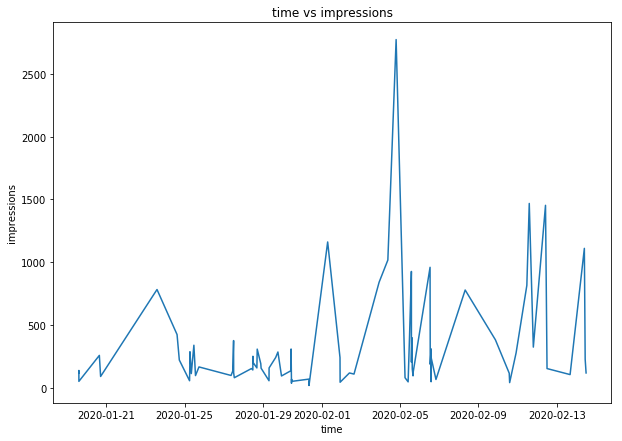

In [11]:
#now it's time to start visualising the data to find out what i can understand about my tweeting

#I'm starting with plotting the number of impressions against time
#is there a relationship between the day of the tweet and the number of impressions it gets
x = tweet_data.time
y = tweet_data.impressions
x_label = 'time'
y_label = 'impressions'

fig, ax = plt.subplots(figsize = (10,7))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(str(x_label) + ' vs ' + str(y_label))
ax.plot(x, y)

From plotting the time as it is (with date and time) I can't interpret much useful from the plot. There doesn't look to be any seasonality or trends in the data. It might well be that there is no trend, or that there's not enough data - 81 tweets isn't many. It also might be that the data still isn't broken down enough to be in a useful format.

In [12]:
# split up time column to give data, time and day
tweet_data['dates'] = pd.to_datetime(tweet_data['time']).dt.date
tweet_data['times'] = pd.to_datetime(tweet_data['time']).dt.time

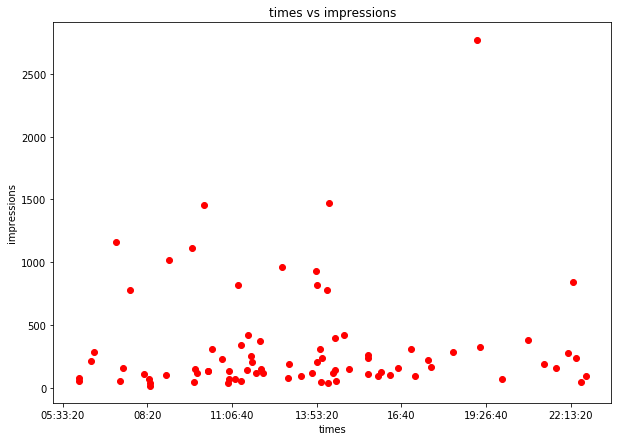

In [13]:
# plot the time of day against the number of impressions of each tweet

x = tweet_data.times
y = tweet_data.impressions
x_label = 'times'
y_label = 'impressions'

fig, ax = plt.subplots(figsize = (10,7))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(str(x_label) + ' vs ' + str(y_label))
ax.plot(x, y, 'ro')

Here, we can garner a little bit more useful information about the tweets I sent over the 28 day period. Most of my tweets have got 0-500 impressions spread right across the day. The earliest I tweeted was around 0545 and the latest close to 2300. Genereally if my tweeets are going to get a higher number of impressions, it's the ones that I do in the morning, rather than the afternoon. There was one tweet with over 2500 impressions.

In [14]:
#It would be good to know if there is a relationship between the variables in the dataframe e.g. does a higher number
#of impressions or likes stem from a higher number of media engagements? To do this a correlation matrix, visualised
#with a coloured background is helpful.
correlation = tweet_data.corr()
correlation.style.background_gradient(cmap='coolwarm').set_precision(2)

,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,follows,media views,media engagements
impressions,1,0.75,0.04,0.53,0.28,0.61,0.56,0.13,0.69,0.29,0.3,0.58,0.71
engagements,0.75,1,0.46,0.66,0.26,0.85,0.74,0.032,0.61,0.26,0.72,0.43,0.97
engagement rate,0.04,0.46,1,0.29,0.14,0.52,0.51,0.018,0.077,0.23,0.42,0.14,0.38
retweets,0.53,0.66,0.29,1,-0.16,0.72,0.6,0.19,0.11,0.29,0.72,0.37,0.54
replies,0.28,0.26,0.14,-0.16,1,0.028,0.097,-0.0096,0.42,-0.064,-0.073,0.15,0.31
likes,0.61,0.85,0.52,0.72,0.028,1,0.75,-0.042,0.22,0.32,0.8,0.42,0.74
user profile clicks,0.56,0.74,0.51,0.6,0.097,0.75,1,0.02,0.25,0.15,0.56,0.33,0.6
url clicks,0.13,0.032,0.018,0.19,-0.0096,-0.042,0.02,1,-0.036,-0.018,-0.024,-0.079,-0.034
hashtag clicks,0.69,0.61,0.077,0.11,0.42,0.22,0.25,-0.036,1,0.049,-0.019,0.36,0.7
detail expands,0.29,0.26,0.23,0.29,-0.064,0.32,0.15,-0.018,0.049,1,0.19,-0.004,0.18


Looking at this correlation plot, there is a really high correlation (0.97) between engagements and media engagements. That means people are engaging with the tweets with media more, but is it meaningful engagement i.e. engagement that I care about i.e. likes/replies/follows etc. Looking at the media engagements column, media engagement is positively correlated to all but URL clicks (which is to be expected due to how twitter shows tweets: media is prioritised over url). Media in my tweets are most highliy correlated to likes and follows, of the engagement that I most care about.

URL clicks have low correlation or negative correlation to all of the other attributes in the data. It looks like tweets with url are most likely to be retweeted rather than anything else.

What about the actual text that is in the tweets? How does that help performace. It would be helpful to look at number of hashtags and sentiment of the tweets and add this to the correlation matrix to see how they affect the engagements and tweet impressions.


In [15]:
#Create a new column in the dataframe which contains the number different hashtags in each tweet.
tweet_data['hashtag'] = tweet_data['Tweet text'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x)) 
tweet_data['hashtag']

0                          [#PhDchat, #AcademicChatter]
1            [#medtwitter, #racism, #unity, #tolerance]
2     [#AcademicValentines, #AcademicChatter, #PhDch...
3                                                    []
4                                                    []
5     [#AcademicChatter, #PhDchat, #acwri, #research...
6          [#datascience, #WomenWhoCode, #datacleaning]
7                          [#prosthetics, #WomenInSTEM]
8     [#amputation, #medtwitter, #vasculardisease, #...
9     [#Python, #DataScience, #GirlsWhoCode, #WomenW...
10                                                   []
11                                                   []
12    [#kaggle, #datascience, #machinelearning, #wom...
13                                                   []
14                                                   []
15                 [#AcademicChatter, #AcademicTwitter]
16                                                   []
17    [#amputation, #meded, #orthotwitter, #medt

In [16]:
#Create a new column in the dataframe which contains the number of different hashtags in each tweet
tweet_data['hashtag number'] = tweet_data.hashtag.apply(lambda y: len(y))
tweet_data.head()

,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,follows,media views,media engagements,dates,times,hashtag,hashtag number
0,Slow progress is better than no progress. #PhD...,2020-02-14 11:54:00+00:00,117.0,1.0,0.008547,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,2020-02-14,11:54:00,"[#PhDchat, #AcademicChatter]",2
1,"Racism is not okay. Not in medicine, not in an...",2020-02-14 10:47:00+00:00,226.0,3.0,0.013274,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0,0,0,2020-02-14,10:47:00,"[#medtwitter, #racism, #unity, #tolerance]",4
2,"Roses are red,\nViolets are blue,\nI want to u...",2020-02-14 09:47:00+00:00,1110.0,14.0,0.012613,2.0,0.0,2.0,4.0,0.0,2.0,0.0,0,151,4,2020-02-14,09:47:00,"[#AcademicValentines, #AcademicChatter, #PhDch...",8
3,@OpenAcademics 🇬🇧🇬🇧🇬🇧 https://t.co/NSf4DVxj1L,2020-02-13 16:18:00+00:00,104.0,4.0,0.038462,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0,25,1,2020-02-13,16:18:00,[],0
4,@itsJozefwithaZ @OpenAcademics @AcademicChatte...,2020-02-12 12:03:00+00:00,152.0,1.0,0.006579,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,2020-02-12,12:03:00,[],0


In [17]:
#Re-calculate the correlation between the different factors in the dataframe and visualise
correlation = tweet_data.corr()
plt.figure(figsize=(15,7))
correlation.style.background_gradient(cmap='coolwarm').set_precision(2)

,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,follows,media views,media engagements,hashtag number
impressions,1,0.75,0.04,0.53,0.28,0.61,0.56,0.13,0.69,0.29,0.3,0.58,0.71,0.57
engagements,0.75,1,0.46,0.66,0.26,0.85,0.74,0.032,0.61,0.26,0.72,0.43,0.97,0.26
engagement rate,0.04,0.46,1,0.29,0.14,0.52,0.51,0.018,0.077,0.23,0.42,0.14,0.38,-0.2
retweets,0.53,0.66,0.29,1,-0.16,0.72,0.6,0.19,0.11,0.29,0.72,0.37,0.54,0.45
replies,0.28,0.26,0.14,-0.16,1,0.028,0.097,-0.0096,0.42,-0.064,-0.073,0.15,0.31,-0.031
likes,0.61,0.85,0.52,0.72,0.028,1,0.75,-0.042,0.22,0.32,0.8,0.42,0.74,0.098
user profile clicks,0.56,0.74,0.51,0.6,0.097,0.75,1,0.02,0.25,0.15,0.56,0.33,0.6,0.14
url clicks,0.13,0.032,0.018,0.19,-0.0096,-0.042,0.02,1,-0.036,-0.018,-0.024,-0.079,-0.034,0.32
hashtag clicks,0.69,0.61,0.077,0.11,0.42,0.22,0.25,-0.036,1,0.049,-0.019,0.36,0.7,0.41
detail expands,0.29,0.26,0.23,0.29,-0.064,0.32,0.15,-0.018,0.049,1,0.19,-0.004,0.18,0.098


<Figure size 1080x504 with 0 Axes>

Number of hashtags is most correlated with number of impressions, followed by retweets and hashtag clicks. It makes sense that generally more hashtags mean higher impressions, but as this isn't a high correlation it suggests not all hashtags are useful for impressions.

In [18]:
#Now to focus on the sentiment of the tweets.
#Create a function to clean the text of the tweets.
def clean_text(text):
    
    # Substitute a select few sybmols with white space
    text = re.sub(r'[#|@|-|?|!]',r' ',text)
    
    # Strip the extra white space
    text = re.sub('\s+',' ', text)
    
    # Convert to lower case
    text = text.lower()
    
    # Lemmatize the words
    text = WordNetLemmatizer().lemmatize(text)
    
    # Tokenize text
    words = word_tokenize(text)
    
    # Find and remove those words that are also in stopwords list from the NLTK corpus
    words = [w for w in words if w not in stopwords.words('english')]
    
    # Join list of words into string format
    text = ' '.join(words)
    
    return text

In [19]:
#Apply the function to the tweet text in the dataframe
tweets = tweet_data['Tweet text'].apply(lambda x: clean_text(x))
 
#Assign a polarity score to each of the tweets in the dataframe
sentiments = []

for tweet in tweets:
    analysis = TextBlob(tweet)
    sentiments.append(analysis.sentiment.polarity)

tweets_df = pd.DataFrame(tweets)

tweet_data['sentiments'] = sentiments

tweet_data

,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,follows,media views,media engagements,dates,times,hashtag,hashtag number,sentiments
0,Slow progress is better than no progress. #PhD...,2020-02-14 11:54:00+00:00,117.0,1.0,0.008547,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,2020-02-14,11:54:00,"[#PhDchat, #AcademicChatter]",2,0.100000
1,"Racism is not okay. Not in medicine, not in an...",2020-02-14 10:47:00+00:00,226.0,3.0,0.013274,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0,0,0,2020-02-14,10:47:00,"[#medtwitter, #racism, #unity, #tolerance]",4,0.500000
2,"Roses are red,\nViolets are blue,\nI want to u...",2020-02-14 09:47:00+00:00,1110.0,14.0,0.012613,2.0,0.0,2.0,4.0,0.0,2.0,0.0,0,151,4,2020-02-14,09:47:00,"[#AcademicValentines, #AcademicChatter, #PhDch...",8,0.000000
3,@OpenAcademics 🇬🇧🇬🇧🇬🇧 https://t.co/NSf4DVxj1L,2020-02-13 16:18:00+00:00,104.0,4.0,0.038462,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0,25,1,2020-02-13,16:18:00,[],0,0.000000
4,@itsJozefwithaZ @OpenAcademics @AcademicChatte...,2020-02-12 12:03:00+00:00,152.0,1.0,0.006579,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,2020-02-12,12:03:00,[],0,-0.025000
5,Today is one of those days where it's importan...,2020-02-12 10:11:00+00:00,1453.0,15.0,0.010323,2.0,1.0,5.0,2.0,0.0,0.0,0.0,0,213,5,2020-02-12,10:11:00,"[#AcademicChatter, #PhDchat, #acwri, #research...",5,0.200000
6,I just published in @TDataScience! Explore and...,2020-02-11 19:16:00+00:00,323.0,15.0,0.046440,4.0,0.0,2.0,5.0,2.0,0.0,2.0,0,0,0,2020-02-11,19:16:00,"[#datascience, #WomenWhoCode, #datacleaning]",3,0.308333
7,@Sydonahi @AcademicChatter @WomenScienceDay Hi...,2020-02-11 14:17:00+00:00,1468.0,145.0,0.098774,8.0,0.0,28.0,18.0,0.0,0.0,2.0,1,88,88,2020-02-11,14:17:00,"[#prosthetics, #WomenInSTEM]",2,-0.500000
8,.@ImperialMed is looking into surgical techniq...,2020-02-11 11:19:00+00:00,815.0,8.0,0.009816,1.0,0.0,3.0,4.0,0.0,0.0,0.0,0,0,0,2020-02-11,11:19:00,"[#amputation, #medtwitter, #vasculardisease, #...",4,0.031250
9,Published my first article on @Medium with @TD...,2020-02-10 22:09:00+00:00,277.0,11.0,0.039711,1.0,0.0,3.0,1.0,6.0,0.0,0.0,0,0,0,2020-02-10,22:09:00,"[#Python, #DataScience, #GirlsWhoCode, #WomenW...",6,0.250000


Really it would have been goot to remove the people tagged in the tweets as this might have influenced the sentiment score.

Text(0, 0.5, 'number of tweets')

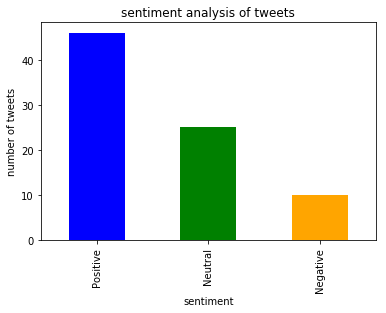

In [20]:
#Count the number of tweets with postive, negative and neutral tweet polarity to give an indication of the sentiment
#of the tweets sent
tweet_data['sentiment_category'] = np.where(tweet_data['sentiments'] > 0, 'Positive', 
                                          np.where(tweet_data['sentiments'] == 0, 'Neutral', 'Negative'))
ax = tweet_data.sentiment_category.value_counts().plot(kind='bar', title="sentiment analysis of tweets", color=["blue", "green", "orange"])
ax.set_xlabel("sentiment")
ax.set_ylabel("number of tweets")

In [21]:
#Re-calculate correlation matrix and plot
correlation = tweet_data.corr()
plt.figure(figsize=(15,7))
plt.tight_layout()
correlation.style.background_gradient(cmap='coolwarm').set_precision(2)

,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,follows,media views,media engagements,hashtag number,sentiments
impressions,1,0.75,0.04,0.53,0.28,0.61,0.56,0.13,0.69,0.29,0.3,0.58,0.71,0.57,-0.18
engagements,0.75,1,0.46,0.66,0.26,0.85,0.74,0.032,0.61,0.26,0.72,0.43,0.97,0.26,-0.22
engagement rate,0.04,0.46,1,0.29,0.14,0.52,0.51,0.018,0.077,0.23,0.42,0.14,0.38,-0.2,-0.00051
retweets,0.53,0.66,0.29,1,-0.16,0.72,0.6,0.19,0.11,0.29,0.72,0.37,0.54,0.45,-0.2
replies,0.28,0.26,0.14,-0.16,1,0.028,0.097,-0.0096,0.42,-0.064,-0.073,0.15,0.31,-0.031,0.025
likes,0.61,0.85,0.52,0.72,0.028,1,0.75,-0.042,0.22,0.32,0.8,0.42,0.74,0.098,-0.23
user profile clicks,0.56,0.74,0.51,0.6,0.097,0.75,1,0.02,0.25,0.15,0.56,0.33,0.6,0.14,-0.13
url clicks,0.13,0.032,0.018,0.19,-0.0096,-0.042,0.02,1,-0.036,-0.018,-0.024,-0.079,-0.034,0.32,-0.0087
hashtag clicks,0.69,0.61,0.077,0.11,0.42,0.22,0.25,-0.036,1,0.049,-0.019,0.36,0.7,0.41,-0.024
detail expands,0.29,0.26,0.23,0.29,-0.064,0.32,0.15,-0.018,0.049,1,0.19,-0.004,0.18,0.098,-0.083


<Figure size 1080x504 with 0 Axes>

There is a slight negative correlation between all the values and sentiment, except one: replies. The correlation here is so small, however, that with the number of Tweets I sent it’s not likely to make a significant impact on my Tweet success.

What have I found out?

From this initial analysis, I think I’ve found out the following:
The time of day I Tweet might be an indication of “success”, but I need more data to determine this. From the limited data I have, late morning-mid afternoon seems to get the most impressions.
Media is likely to increase the engagement of my Tweets.
Merely increasing the number of hashtags in a Tweet does not guarantee a more “successful” Tweet — the key is to pick the hashtags carefully.
How happy or otherwise my Tweets are doesn’t have a major impact on their “success”.